In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch as th

import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['text.latex.preamble'] = r"\usepackage{lmodern} \usepackage{amsmath}"
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
        #   'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

In [2]:

class Bandit():
  ''' Class which takes the no of action, mean and variance as input '''
  def __init__(self,n_action=10,mean=0,variance=1, name=None):
    self.n_action = n_action
    self.mean = mean 
    self.center_variance = variance
    self.action_variance = variance
    if name == 'near zero':
      self.q_star = np.arange(-5,-2, (3/self.n_action)) # creating a linear space of q_star
    elif name == 'near one':
      self.q_star = np.arange(1,5, (4/self.n_action))
    elif name == 'evenly spaced':
      self.q_star = np.arange(-3,3, (6/self.n_action))
    else:
      self.q_star = np.random.normal(self.mean,self.center_variance,self.n_action)
    self.s_q_star = self.compute_sigmoid_q_star()
  
  def compute_sigmoid_q_star(self):
    num_samples = int(1e7)
    s_qstar = np.zeros(self.n_action)
    for i in range(len(self.q_star)):
      real_rewards = np.random.normal(self.q_star[i], self.action_variance , num_samples)
      sigmoid_rewards = 1/(1+np.exp(-real_rewards))
      s_qstar[i] = np.mean(sigmoid_rewards)
    return s_qstar

  def return_no_actions(self):
    return self.n_action
  
  def optimal_action(self):
    return np.argmax(self.q_star)
  
  def pull_numpy(self,action):
    # print(self.q_star[action])
    s = np.random.normal(self.q_star[action], 1 , 1)
    # print(s)
    sigmoid_s = 1/(1+np.exp(-s))
    assert sigmoid_s <= 1 and sigmoid_s >= 0
    return sigmoid_s[0]

  def pull(self,action):
    action_th = th.tensor(self.q_star[action])
    variance_th = th.tensor(self.action_variance)
    std = variance_th.repeat(action_th.size())**0.5
    s = th.normal(action_th, std)
    sigmoid_s = 1/(1+th.exp(-s))
    assert sigmoid_s.all() <= 1 and sigmoid_s.all() >= 0
    return sigmoid_s
  
  def return_exp_optimal_reawrd(self):
    return np.max(self.q_star)

In [3]:
def cross_learning(runs,epochs,alpha,bandit):
    
    optimal_actions = np.zeros((runs,epochs))
    reward_overall = th.zeros(runs,epochs)
    policy = th.ones(epochs,bandit.return_no_actions())*1/bandit.return_no_actions()

    for j in range(runs):
        action = th.distributions.Categorical(policy).sample()
        reward = bandit.pull(action)
        reward_overall[j,:] = reward
        optimal_actions[j,:] = (action.numpy() == bandit.optimal_action())
        mask = th.zeros(epochs,bandit.return_no_actions())
        index = th.arange(epochs)
        mask[index,action] = 1
        policy = policy + alpha*th.einsum('ij,i->ij',mask - policy, reward)
    
    return reward_overall, optimal_actions



In [4]:
def taylor_replicator_dynamics(alpha,bandit,runs):
    dt = alpha
    time = np.arange(0,alpha*runs,dt)
    mean_reward_trd = np.zeros(len(time))
    s_qstar = bandit.s_q_star
    x = np.ones(bandit.return_no_actions())*1/bandit.return_no_actions()

    for i in range(len(time)):
        dx = np.zeros(len(x))
        dx = x*(s_qstar - np.dot(s_qstar,x))
        x = x + dx*dt
        mean_reward_trd[i] = np.dot(x,s_qstar)
    return mean_reward_trd

In [13]:
def maynard_cross_learning(runs,epochs,alpha,alpha_baseline,bandit):

    optimal_actions = np.zeros((runs,epochs))
    reward_overall = th.zeros(runs,epochs)
    policy = th.ones(epochs,bandit.return_no_actions())*1/bandit.return_no_actions()
    mean_reward = th.zeros(epochs)
    
    for j in range(runs):

        action = th.distributions.Categorical(policy).sample()
        reward = bandit.pull(action)

        reward_overall[j,:] = reward

        if j == 0:
            mean_reward = reward 
        else:
            mean_reward = alpha_baseline*reward + (1-alpha_baseline)*mean_reward
        

        optimal_actions[j,:] = (action.numpy() == bandit.optimal_action())
        mask = th.zeros(epochs,bandit.return_no_actions())
        index = th.arange(epochs)
        mask[index,action] = 1

        policy = policy + alpha*th.einsum('ij,i->ij',mask - policy, reward/mean_reward)

        # bound policy between 0 and 1, this only happens when alpha is large
        policy = th.clamp(policy,0,1)
    
    return reward_overall, optimal_actions

In [6]:
def maynard_replicator_dynamics(alpha,bandit,runs):
    dt = alpha
    time = np.arange(0,alpha*runs,dt)
    mean_reward_mrd = np.zeros(len(time))
    s_qstar = bandit.s_q_star
    x = np.ones(bandit.return_no_actions())*1/bandit.return_no_actions()


    for i in range(len(time)):
        dx = np.zeros(len(x))
        dx = x*(s_qstar - np.dot(s_qstar,x))/np.dot(x,s_qstar)
        x = x + dx*dt
        mean_reward_mrd[i] = np.dot(x,s_qstar)
    return mean_reward_mrd

<>:83: SyntaxWarning: invalid escape sequence '\%'
<>:83: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_975820/1819306639.py:83: SyntaxWarning: invalid escape sequence '\%'
  axs[3].set_ylabel('\% Optimal actions', fontsize=fontsize, rotation=270)


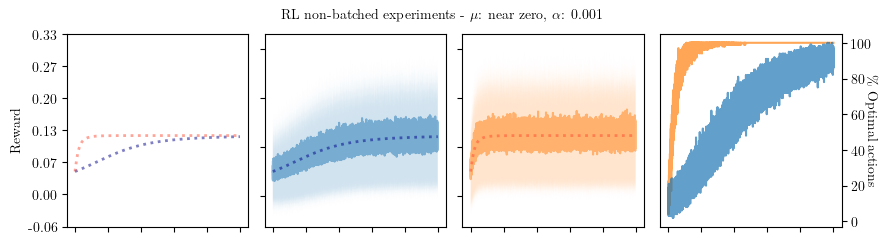

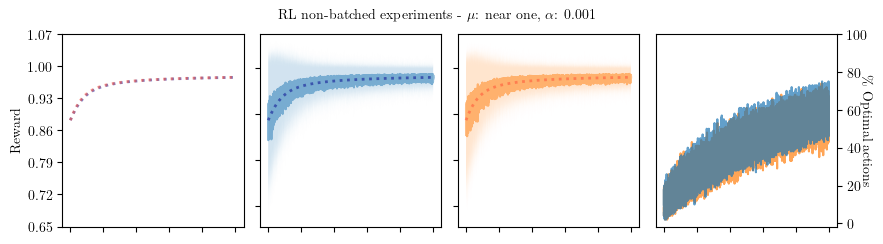

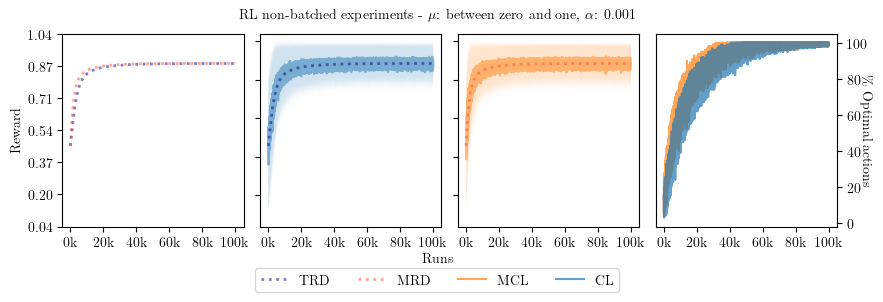

In [27]:
r = 0
for name in ['near zero','near one','evenly spaced']:
        
        bandit = Bandit(n_action=10,mean=0,variance=1, name=name)
        # print(bandit.s_q_star)

        runs = 100000
        epochs = 100
        alpha = 0.001
        alpha_baseline = 0.01

        reward_overall_cl, optimal_actions_cl = cross_learning(runs,epochs,alpha,bandit)
        mean_reward_trd = taylor_replicator_dynamics(alpha,bandit,runs)
        reward_overall_mcl, optimal_actions_mcl = maynard_cross_learning(runs,epochs,alpha,alpha_baseline,bandit)
        mean_reward_mrd = maynard_replicator_dynamics(alpha,bandit,runs)

        #plot stuff
        plt.rcParams['figure.figsize'] = [10, 2.5]
        fig = plt.figure()
        fontsize=10
        plt.rcParams.update({'font.size': fontsize})
        axs = fig.subplots(1,4, sharex=True)
        axs[0].sharey(axs[1])
        axs[1].sharey(axs[2])
        colors = ['#1f77b4', '#ff7f0e', '#ff4b33', '#00008b']
        lines_labels=[]

        max_cl = max(reward_overall_cl.numpy().mean(axis=1) + reward_overall_cl.numpy().std(axis=1))
        max_mcl = max(reward_overall_mcl.numpy().mean(axis=1) + reward_overall_mcl.numpy().std(axis=1))
        max_reward = max_cl if max_cl > max_mcl else max_mcl
        min_cl = min(reward_overall_cl.numpy().mean(axis=1) - reward_overall_cl.numpy().std(axis=1))
        min_mcl = min(reward_overall_mcl.numpy().mean(axis=1) - reward_overall_mcl.numpy().std(axis=1))
        min_reward = min_cl if min_cl < min_mcl else min_mcl


        loosely_dashdotdotted = (0, (3, 5, 1, 5, 1, 5))
        reward_steps = (max_reward - min_reward)/6
        # print(min_reward,max_reward)
        # print(reward_steps)
        reward_ticks = [min_reward+i*reward_steps for i in range(7)]
        # print(reward_ticks)

        step_x = runs/5


        axs[0].plot(range(runs),mean_reward_trd, label='TRD', color=colors[3], linestyle='dotted', linewidth=2, alpha=0.5)
        axs[0].plot(range(runs),mean_reward_mrd, label='MRD', color=colors[2], linestyle='dotted', linewidth=2, alpha=0.5)
        axs[0].set_yticks(reward_ticks)
        axs[0].set_yticklabels([f'{i:.2f}' for i in reward_ticks], fontsize=fontsize)
        axs[0].set_ylim(reward_ticks[0],reward_ticks[-1])
        axs[0].set_ylabel('Reward', fontsize=fontsize)
        
        if name == 'evenly spaced':
                axs[0].set_xticks([i for i in np.arange(0,round(runs+step_x),step_x)])
                axs[0].set_xticklabels([f'{i/1000:.0f}k' for i in np.arange(0,round(runs+step_x),step_x)], fontsize=fontsize)
                # axs[0].set_ylim(min_reward,max_reward+reward_steps)
        else:
                axs[0].set_xticks([i for i in np.arange(0,round(runs+step_x),step_x)])
                axs[0].tick_params(labelbottom=False)
                



        axs[1].plot(range(runs),reward_overall_cl.numpy().mean(axis=1), label='CL', color=colors[0], alpha=0.5)
        axs[1].plot(range(runs),mean_reward_trd, label='TRD', color=colors[3], linestyle='dotted', alpha=0.5, linewidth=2)
        axs[1].fill_between(range(runs),reward_overall_cl.numpy().mean(axis=1) - reward_overall_cl.numpy().std(axis=1),reward_overall_cl.numpy().mean(axis=1) + reward_overall_cl.numpy().std(axis=1),facecolor=colors[0], alpha=0.2)
        axs[2].plot(range(runs),reward_overall_mcl.numpy().mean(axis=1), label='MCL', color=colors[1], alpha=0.5)
        axs[2].plot(range(runs),mean_reward_mrd, label='MRD', color=colors[2], linestyle='dotted', alpha=0.5, linewidth=2)
        axs[2].fill_between(range(runs),reward_overall_mcl.numpy().mean(axis=1) - reward_overall_mcl.numpy().std(axis=1),reward_overall_mcl.numpy().mean(axis=1) + reward_overall_mcl.numpy().std(axis=1),facecolor=colors[1], alpha=0.2)
        axs[1].tick_params(labelleft=False)
        axs[2].tick_params(labelleft=False)
        if name in ['near zero','near one']:
                axs[1].tick_params(labelbottom=False)
                axs[2].tick_params(labelbottom=False)


        axs[3].plot(range(runs),optimal_actions_mcl.mean(axis=1)*100,label='MCL', color=colors[1], alpha=0.7)
        axs[3].plot(range(runs),optimal_actions_cl.mean(axis=1)*100,label='CL', color=colors[0], alpha=0.7)
        axs[3].yaxis.tick_right()
        axs[3].yaxis.set_label_position("right")
        axs[3].set_yticks([i for i in np.arange(0,120,20)])
        axs[3].set_yticklabels([f'{i}' for i in np.arange(0,120,20)], fontsize=fontsize)
        axs[3].set_ylabel('\% Optimal actions', fontsize=fontsize, rotation=270)
        if name in ['near zero','near one']:
                axs[0].tick_params(labelbottom=False)
                axs[3].tick_params(labelbottom=False)

        # save figure 

        plt.subplots_adjust(wspace=0.09, hspace=0.05)
        # set common x-axis label

        # set legend outside the plot
        
        lines_labels = [axs[0].get_legend_handles_labels()]
        lines_labels.append(axs[3].get_legend_handles_labels())
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

        if name == 'evenly spaced':
                name = 'between zero and one'
        title = r'RL non-batched experiments - $\mu$: '+str(name)+ r', $\alpha$: ' + str(alpha)
        fig.suptitle(title, fontsize=fontsize)
        if name == 'between zero and one':
                fig.text(0.5, -0.02, 'Runs', ha='center', va='center', fontsize=fontsize)
                fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.03), ncol=4, fontsize=fontsize)
        r += 1
        plt.savefig(f"rl_non_batched_exp_{r}.pdf", bbox_inches='tight',dpi=900)


<>:83: SyntaxWarning: invalid escape sequence '\%'
<>:83: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_992467/1071601617.py:83: SyntaxWarning: invalid escape sequence '\%'
  axs[3].set_ylabel('\% Optimal actions', fontsize=fontsize, rotation=270)


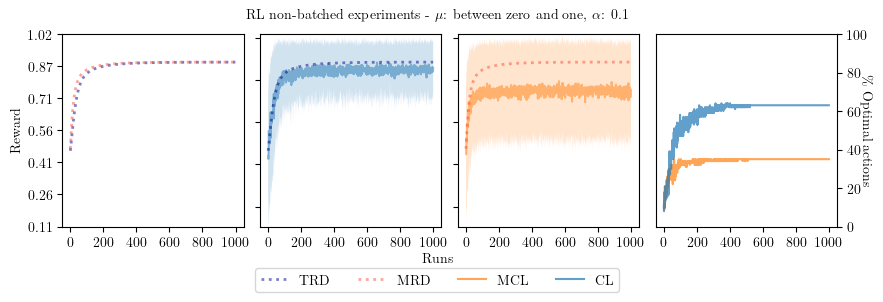

In [15]:
r = 4
for name in ['evenly spaced']:
        
        bandit = Bandit(n_action=10,mean=0,variance=1, name=name)
        # print(bandit.s_q_star)

        runs = 1000
        epochs = 100
        alpha = 0.1
        alpha_baseline = 0.01

        reward_overall_cl, optimal_actions_cl = cross_learning(runs,epochs,alpha,bandit)
        mean_reward_trd = taylor_replicator_dynamics(alpha,bandit,runs)
        reward_overall_mcl, optimal_actions_mcl = maynard_cross_learning(runs,epochs,alpha,alpha_baseline,bandit)
        mean_reward_mrd = maynard_replicator_dynamics(alpha,bandit,runs)

        #plot stuff
        plt.rcParams['figure.figsize'] = [10, 2.5]
        fig = plt.figure()
        fontsize=10
        plt.rcParams.update({'font.size': fontsize})
        axs = fig.subplots(1,4, sharex=True)
        axs[0].sharey(axs[1])
        axs[1].sharey(axs[2])
        colors = ['#1f77b4', '#ff7f0e', '#ff4b33', '#00008b']
        lines_labels=[]

        max_cl = max(reward_overall_cl.numpy().mean(axis=1) + reward_overall_cl.numpy().std(axis=1))
        max_mcl = max(reward_overall_mcl.numpy().mean(axis=1) + reward_overall_mcl.numpy().std(axis=1))
        max_reward = max_cl if max_cl > max_mcl else max_mcl
        min_cl = min(reward_overall_cl.numpy().mean(axis=1) - reward_overall_cl.numpy().std(axis=1))
        min_mcl = min(reward_overall_mcl.numpy().mean(axis=1) - reward_overall_mcl.numpy().std(axis=1))
        min_reward = min_cl if min_cl < min_mcl else min_mcl


        loosely_dashdotdotted = (0, (3, 5, 1, 5, 1, 5))
        reward_steps = (max_reward - min_reward)/6
        # print(min_reward,max_reward)
        # print(reward_steps)
        reward_ticks = [min_reward+i*reward_steps for i in range(7)]
        # print(reward_ticks)

        step_x = runs/5


        axs[0].plot(range(runs),mean_reward_trd, label='TRD', color=colors[3], linestyle='dotted', linewidth=2, alpha=0.5)
        axs[0].plot(range(runs),mean_reward_mrd, label='MRD', color=colors[2], linestyle='dotted', linewidth=2, alpha=0.5)
        axs[0].set_yticks(reward_ticks)
        axs[0].set_yticklabels([f'{i:.2f}' for i in reward_ticks], fontsize=fontsize)
        axs[0].set_ylim(reward_ticks[0],reward_ticks[-1])
        axs[0].set_ylabel('Reward', fontsize=fontsize)
        
        if name == 'evenly spaced':
                axs[0].set_xticks([i for i in np.arange(0,round(runs+step_x),step_x)])
                axs[0].set_xticklabels([f'{i:.0f}' for i in np.arange(0,round(runs+step_x),step_x)], fontsize=fontsize)
                # axs[0].set_ylim(min_reward,max_reward+reward_steps)
        else:
                axs[0].set_xticks([i for i in np.arange(0,round(runs+step_x),step_x)])
                axs[0].tick_params(labelbottom=False)
                



        axs[1].plot(range(runs),reward_overall_cl.numpy().mean(axis=1), label='CL', color=colors[0], alpha=0.5)
        axs[1].plot(range(runs),mean_reward_trd, label='TRD', color=colors[3], linestyle='dotted', alpha=0.5, linewidth=2)
        axs[1].fill_between(range(runs),reward_overall_cl.numpy().mean(axis=1) - reward_overall_cl.numpy().std(axis=1),reward_overall_cl.numpy().mean(axis=1) + reward_overall_cl.numpy().std(axis=1),facecolor=colors[0], alpha=0.2)
        axs[2].plot(range(runs),reward_overall_mcl.numpy().mean(axis=1), label='MCL', color=colors[1], alpha=0.5)
        axs[2].plot(range(runs),mean_reward_mrd, label='MRD', color=colors[2], linestyle='dotted', alpha=0.5, linewidth=2)
        axs[2].fill_between(range(runs),reward_overall_mcl.numpy().mean(axis=1) - reward_overall_mcl.numpy().std(axis=1),reward_overall_mcl.numpy().mean(axis=1) + reward_overall_mcl.numpy().std(axis=1),facecolor=colors[1], alpha=0.2)
        axs[1].tick_params(labelleft=False)
        axs[2].tick_params(labelleft=False)
        if name in ['near zero','near one']:
                axs[1].tick_params(labelbottom=False)
                axs[2].tick_params(labelbottom=False)


        axs[3].plot(range(runs),optimal_actions_mcl.mean(axis=1)*100,label='MCL', color=colors[1], alpha=0.7)
        axs[3].plot(range(runs),optimal_actions_cl.mean(axis=1)*100,label='CL', color=colors[0], alpha=0.7)
        axs[3].yaxis.tick_right()
        axs[3].yaxis.set_label_position("right")
        axs[3].set_yticks([i for i in np.arange(0,120,20)])
        axs[3].set_yticklabels([f'{i}' for i in np.arange(0,120,20)], fontsize=fontsize)
        axs[3].set_ylabel('\% Optimal actions', fontsize=fontsize, rotation=270)
        if name in ['near zero','near one']:
                axs[0].tick_params(labelbottom=False)
                axs[3].tick_params(labelbottom=False)

        # save figure 

        plt.subplots_adjust(wspace=0.09, hspace=0.05)
        # set common x-axis label

        # set legend outside the plot
        
        lines_labels = [axs[0].get_legend_handles_labels()]
        lines_labels.append(axs[3].get_legend_handles_labels())
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

        if name == 'evenly spaced':
                name = 'between zero and one'
        title = r'RL non-batched experiments - $\mu$: '+str(name)+ r', $\alpha$: ' + str(alpha)
        fig.suptitle(title, fontsize=fontsize)
        if name == 'between zero and one':
                fig.text(0.5, -0.02, 'Runs', ha='center', va='center', fontsize=fontsize)
                fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.03), ncol=4, fontsize=fontsize)
        r += 1
        plt.savefig(f"rl_non_batched_exp_{r}.pdf", bbox_inches='tight',dpi=900)